# Model evaluation
Calculate all model results and format them for the paper


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob
import os

#reimport
import evaluation as eval
import importlib
importlib.reload(eval)

import utils
importlib.reload(utils)

<module 'utils' from '/Users/conorosullivan/Documents/git/COASTAL_MONITORING/sentinel2-irish-coastal-segmentation/src/utils.py'>

In [3]:
model_file = "../models/SIVE_04JUN2025/"
model_paths = glob.glob(model_file + '*.pth')
print(f"Model files found: {len(model_paths)}")

Model files found: 20


In [4]:
# Points dictionary
points_dict = np.load('../data/SIVE/points_dict.npy', allow_pickle=True).item()
points_dict.keys()

dict_keys(['20240623T114351_tramore', '20221211T114501_rossnowlagh', '20221204T115451_rossnowlagh', '20221116T114349_rossnowlagh', '20221007T114349_rossnowlagh', '20220922T114401_rossnowlagh', '20220910T115359_rossnowlagh', '20220905T115411_rossnowlagh', '20220813T114401_rossnowlagh', '20220811T115409_rossnowlagh', '20220722T115409_rossnowlagh', '20220607T115411_rossnowlagh', '20220604T114401_rossnowlagh', '20220523T115359_rossnowlagh', '20220408T115401_rossnowlagh', '20220326T114351_rossnowlagh', '20220319T115401_rossnowlagh', '20240211T113311_portrane', '20220323T113321_portrane', '20201002T114401_portrane', '20190707T113321_portrane', '20190207T113321_portmarnock', '20171129T113419_portmarnock', '20230904T113321_bull_island', '20230604T114349_bull_island', '20230530T114351_bull_island', '20230420T114351_bull_island', '20190920T113319_bull_island', '20190826T113321_bull_island', '20190707T113321_bull_island', '20190627T113321_bull_island', '20190501T114351_bull_island', '20190411T114

In [5]:
def get_all_results(model_paths, test_paths,points_dict):

    """Get results for all models in model_paths on test data in test_paths"""
    results = []

    for i,model_path in enumerate(model_paths):
        model_name = os.path.basename(model_path)
        print(f"Processing model {i+1}/{len(model_paths)}: {model_name}")

        model, meta_data = utils.get_model(model_path)
        
        targets = []
        preds = []

        for path in test_paths:
            image,  pred_full = eval.get_combined_pred(model,meta_data,points_dict, path, batch_size=1)

            targets.append(image[-1])
            preds.append(pred_full)

        test_metrics, test_arr = eval.eval_metrics(targets, preds)

        row = meta_data | test_metrics
        results.append(row)
        
    return results

def plot_all_predictions(model, meta_data, test_paths, batch_size=1,crop_remove=200):
    """Plot predictions for all test data in test_paths using model and meta_data"""

    for path in test_paths:
        image,  pred_full = eval.get_combined_pred(model,meta_data,points_dict, path, batch_size=1)
        image = image[:,crop_remove:-crop_remove, crop_remove:-crop_remove]
        pred_full = pred_full[crop_remove:-crop_remove, crop_remove:-crop_remove]

        ID = os.path.basename(path).split('.')[0]
        points = points_dict[ID][1]

        fig, ax = plt.subplots(1, 3, figsize=(12, 6))
        rgb_image = utils.get_rgb(image, r=0,b=2,contrast=0.3)
        rgb_image = utils.enhance_rgb(rgb_image,1.5)



        ax[0].imshow(rgb_image)
        ax[0].set_title("RGB Image")
        
        ax[1].imshow(1-image[-1], cmap='gray')
        ax[1].set_title("Target")

        ax[2].imshow(1-pred_full, cmap='gray')
        ax[2].set_title("Prediction")

        for a in ax:
            a.set_xticks([])
            a.set_yticks([])
        
        plt.show()


## Seen-location test set

In [7]:
# Test data
target_pos = -1

test_file = '../data/SIVE/test_1/'
test_paths = glob.glob(test_file + '*.npy')
test_targets = [np.load(file)[target_pos] for file in test_paths]
test_input = [np.load(file)[0:target_pos] for file in test_paths]

print("Test dimensions:")
print(np.shape(test_targets[0]))
print(np.shape(test_input[0]))

Test dimensions:
(750, 650)
(5, 750, 650)


In [ ]:
results = get_all_results(model_paths, test_paths,points_dict)
results_df = pd.DataFrame(results)
results_df.to_csv('../data/results/inlocation_results.csv', index=False)

Processing model 1/20: SIVE_04JUN2025_HED_ImageNet_frozen_guided_DICE.pth
Processing model 2/20: SIVE_04JUN2025_HED_BigEarthNet_frozen_unguided_wBCE.pth
Processing model 3/20: SIVE_04JUN2025_HED_BigEarthNet_trainable_unguided_DICE.pth
Processing model 4/20: SIVE_04JUN2025_HED_ImageNet_trainable_unguided_wBCE.pth
Processing model 5/20: SIVE_04JUN2025_HED_BigEarthNet_trainable_guided_wBCE.pth
Processing model 6/20: SIVE_04JUN2025_HED_ImageNet_frozen_guided_wBCE.pth
Processing model 7/20: SIVE_04JUN2025_HED_BigEarthNet_frozen_unguided_DICE.pth
Processing model 8/20: SIVE_04JUN2025_HED_BigEarthNet_trainable_unguided_wBCE.pth
Processing model 9/20: SIVE_04JUN2025_HED_BigEarthNet_trainable_guided_DICE.pth
Processing model 10/20: SIVE_04JUN2025_HED_ImageNet_trainable_unguided_DICE.pth
Processing model 11/20: SIVE_04JUN2025_HED_SimpleCNN_trainable_guided_DICE.pth
Processing model 12/20: SIVE_04JUN2025_HED_SimpleCNN_trainable_unguided_wBCE.pth
Processing model 13/20: SIVE_04JUN2025_HED_BigEarth

In [10]:
results_df = pd.read_csv('../data/results/inlocation_results.csv')
results_df.sort_values(by=['backbone','freeze_backbone','loss_function','guidance',], ascending=False).drop(columns=['name', 'date','arcitecture'])

backbone freeze_backbone  guidance loss_function  accuracy  precision  \
15    SimpleCNN       trainable      True          wBCE  0.999497   0.608509   
11    SimpleCNN       trainable     False          wBCE  0.999380   0.534171   
10    SimpleCNN       trainable      True          DICE  0.999510   0.624179   
16    SimpleCNN       trainable     False          DICE  0.999552   0.663106   
17     ImageNet       trainable      True          wBCE  0.999466   0.589038   
3      ImageNet       trainable     False          wBCE  0.999403   0.544666   
13     ImageNet       trainable      True          DICE  0.999479   0.597998   
9      ImageNet       trainable     False          DICE  0.999464   0.589758   
5      ImageNet          frozen      True          wBCE  0.999199   0.403603   
14     ImageNet          frozen     False          wBCE  0.998654   0.264620   
0      ImageNet          frozen      True          DICE  0.999481   0.603185   
19     ImageNet          frozen     False          DICE  0.999376   0.522304   
4   BigEarthNet       trainable      True          wBCE  0.999491   0.610528   
7   BigEarthNet       trainable     False          wBCE  0.999335   0.507950   
8   BigEarthNet       trainable      True          DICE  0.999487   0.602340   
2   BigEarthNet       trainable     False          DICE  0.999458   0.583718   
18  BigEarthNet          frozen      True          wBCE  0.999239   0.428657   
1   BigEarthNet          frozen     False          wBCE  0.998624   0.247381   
12  BigEarthNet          frozen      True          DICE  0.999447   0.567413   
6   BigEarthNet          frozen     False          DICE  0.999410   0.548505   

      recall        f1       iou       fom  
15  0.616026  0.612209  0.446013  0.950684  
11  0.597592  0.562541  0.397204  0.863556  
10  0.598089  0.610696  0.444713  0.914677  
16  0.606654  0.629912  0.468027  0.857718  
17  0.605904  0.597276  0.429570  0.945224  
3   0.600394  0.570396  0.402899  0.882895  
13  0.580319  0.588932  0.421343  0.928022  
9   0.569015  0.578853  0.409666  0.907096  
5   0.480825  0.438496  0.282443  0.836089  
14  0.501901  0.341199  0.208872  0.541147  
0   0.576199  0.589154  0.420627  0.906959  
19  0.483575  0.501320  0.337420  0.770855  
4   0.620035  0.615189  0.447490  0.952775  
7   0.588603  0.543138  0.376517  0.840329  
8   0.570837  0.585915  0.418453  0.908976  
2   0.564415  0.573537  0.404725  0.897991  
18  0.506682  0.464237  0.304236  0.848365  
1   0.452015  0.313156  0.188798  0.547176  
12  0.547736  0.557188  0.392673  0.911866  
6   0.509060  0.527116  0.362271  0.796323

In [11]:
# Identify best model
best_model = results_df.sort_values(by=['fom'], ascending=False).iloc[0]
best_model_name = best_model['name']
print("Best model:")
print(best_model)

Best model:
name               SIVE_04JUN2025_HED_BigEarthNet_trainable_guide...
date                                                       04JUN2025
arcitecture                                                      HED
backbone                                                 BigEarthNet
freeze_backbone                                            trainable
guidance                                                        True
loss_function                                                   wBCE
accuracy                                                    0.999491
precision                                                   0.610528
recall                                                      0.620035
f1                                                          0.615189
iou                                                          0.44749
fom                                                         0.952775
Name: 4, dtype: object


Model metadata:
name: SIVE_04JUN2025_HED_BigEarthNet_trainable_guided_wBCE.pth
date: 04JUN2025
arcitecture: HED
backbone: BigEarthNet
freeze_backbone: trainable
guidance: True
loss_function: wBCE


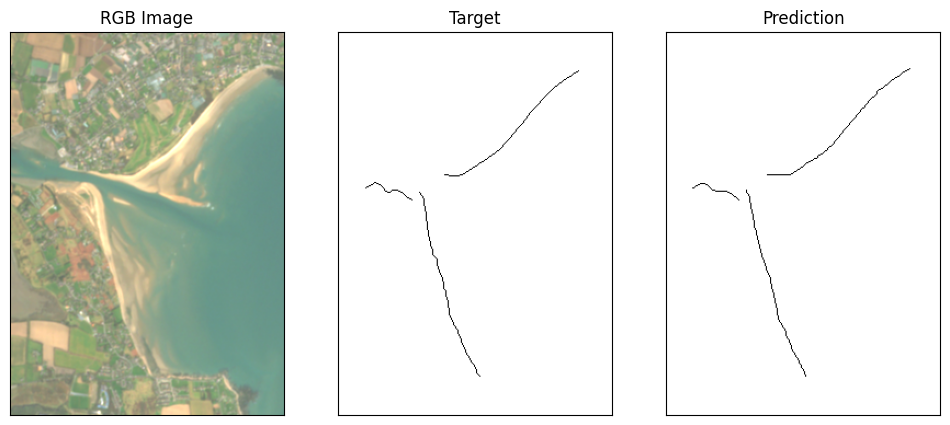

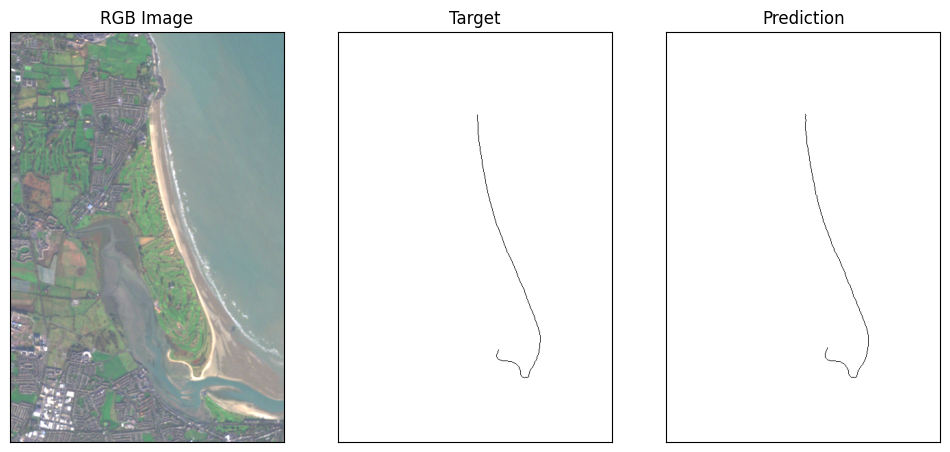

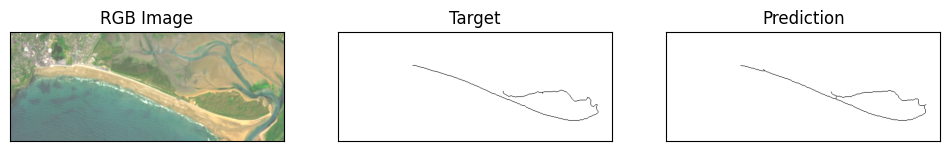

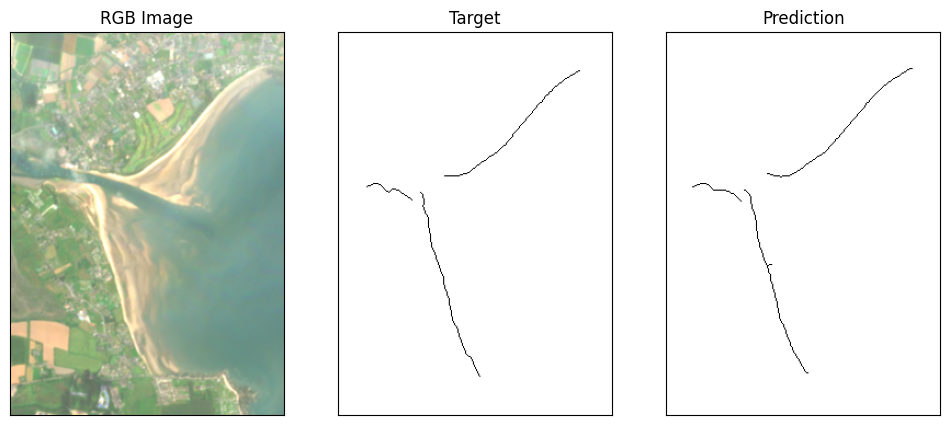

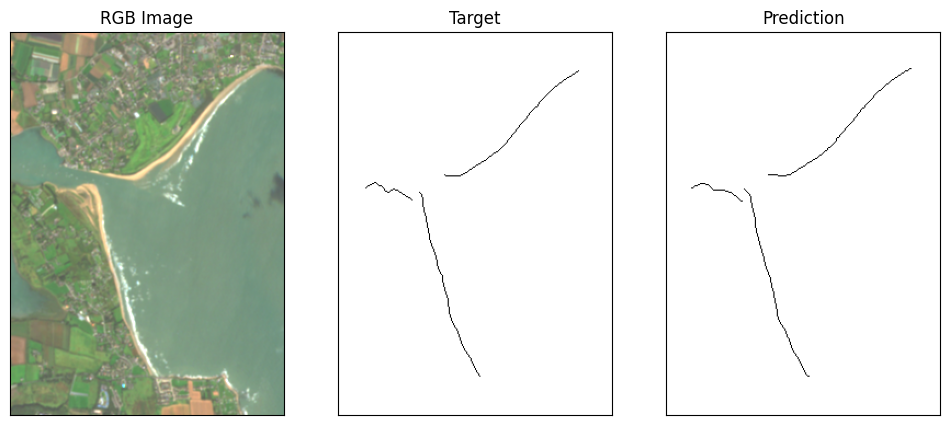

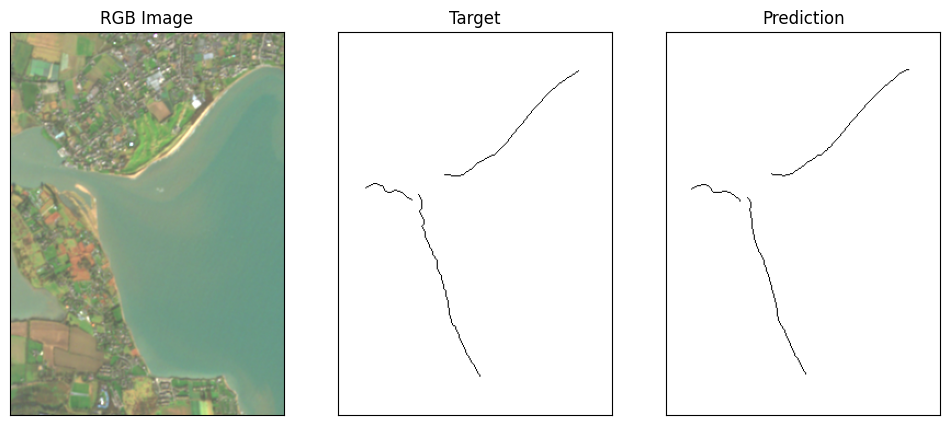

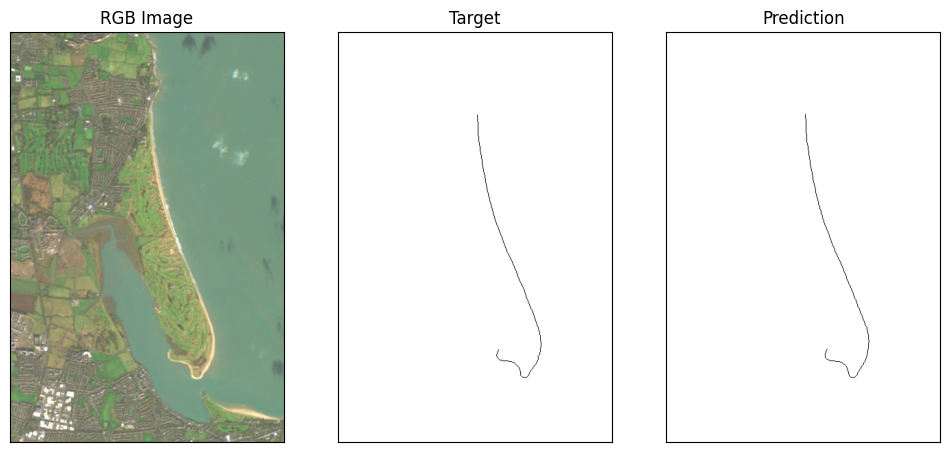

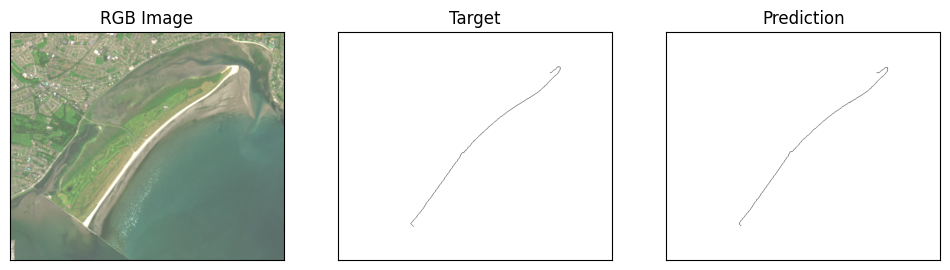

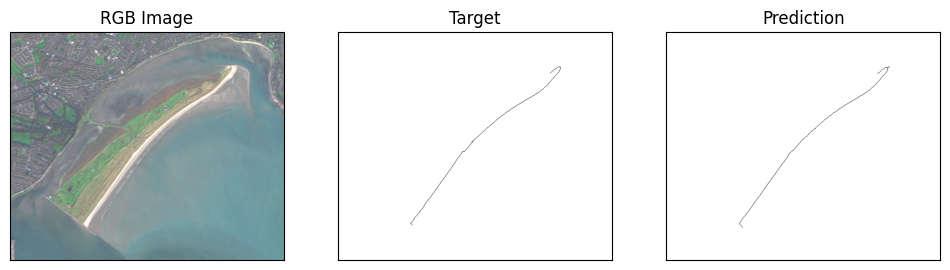

In [12]:
model_path = f'../models/SIVE_04JUN2025/{best_model_name}'
model, meta_data = utils.get_model(model_path)

print("Model metadata:")
for key, value in meta_data.items():
    print(f"{key}: {value}")

plot_all_predictions(model, meta_data, test_paths)

## Unseen-location 

In [15]:
# Test data
target_pos = -1

test_file = '../data/SIVE/test_2/'
test_paths = glob.glob(test_file + '*.npy')
test_targets = [np.load(file)[target_pos] for file in test_paths]
test_input = [np.load(file)[0:target_pos] for file in test_paths]

print("Test dimensions:")
print(np.shape(test_targets[0]))
print(np.shape(test_input[0]))

Test dimensions:
(800, 700)
(5, 800, 700)


In [ ]:
results = get_all_results(model_paths, test_paths,points_dict)
results_df = pd.DataFrame(results)
results_df.to_csv('../data/results/outlocation_results.csv', index=False)

Processing model 1/20: SIVE_04JUN2025_HED_ImageNet_frozen_guided_DICE.pth
Processing model 2/20: SIVE_04JUN2025_HED_BigEarthNet_frozen_unguided_wBCE.pth
Processing model 3/20: SIVE_04JUN2025_HED_BigEarthNet_trainable_unguided_DICE.pth
Processing model 4/20: SIVE_04JUN2025_HED_ImageNet_trainable_unguided_wBCE.pth
Processing model 5/20: SIVE_04JUN2025_HED_BigEarthNet_trainable_guided_wBCE.pth
Processing model 6/20: SIVE_04JUN2025_HED_ImageNet_frozen_guided_wBCE.pth
Processing model 7/20: SIVE_04JUN2025_HED_BigEarthNet_frozen_unguided_DICE.pth
Processing model 8/20: SIVE_04JUN2025_HED_BigEarthNet_trainable_unguided_wBCE.pth
Processing model 9/20: SIVE_04JUN2025_HED_BigEarthNet_trainable_guided_DICE.pth
Processing model 10/20: SIVE_04JUN2025_HED_ImageNet_trainable_unguided_DICE.pth
Processing model 11/20: SIVE_04JUN2025_HED_SimpleCNN_trainable_guided_DICE.pth
Processing model 12/20: SIVE_04JUN2025_HED_SimpleCNN_trainable_unguided_wBCE.pth
Processing model 13/20: SIVE_04JUN2025_HED_BigEarth

KeyboardInterrupt: 

In [13]:
results_df = pd.read_csv('../data/results/outlocation_results.csv')
results_df.sort_values(by=['backbone','freeze_backbone','loss_function','guidance',], ascending=False).drop(columns=['name', 'date','arcitecture'])

backbone freeze_backbone  guidance loss_function  accuracy  precision  \
15    SimpleCNN       trainable      True          wBCE  0.999630   0.549235   
11    SimpleCNN       trainable     False          wBCE  0.999463   0.358329   
10    SimpleCNN       trainable      True          DICE  0.999662   0.606989   
16    SimpleCNN       trainable     False          DICE  0.999582   0.489013   
17     ImageNet       trainable      True          wBCE  0.999579   0.487980   
3      ImageNet       trainable     False          wBCE  0.999407   0.294690   
13     ImageNet       trainable      True          DICE  0.999659   0.593273   
9      ImageNet       trainable     False          DICE  0.999521   0.408697   
5      ImageNet          frozen      True          wBCE  0.999323   0.225169   
14     ImageNet          frozen     False          wBCE  0.999063   0.179152   
0      ImageNet          frozen      True          DICE  0.999603   0.517850   
19     ImageNet          frozen     False          DICE  0.999532   0.417894   
4   BigEarthNet       trainable      True          wBCE  0.999616   0.535284   
7   BigEarthNet       trainable     False          wBCE  0.999449   0.337081   
8   BigEarthNet       trainable      True          DICE  0.999656   0.599497   
2   BigEarthNet       trainable     False          DICE  0.999570   0.467325   
18  BigEarthNet          frozen      True          wBCE  0.999351   0.254415   
1   BigEarthNet          frozen     False          wBCE  0.999067   0.123343   
12  BigEarthNet          frozen      True          DICE  0.999623   0.547120   
6   BigEarthNet          frozen     False          DICE  0.999559   0.451114   

      recall        f1       iou       fom  
15  0.532001  0.540176  0.386425  0.902181  
11  0.402559  0.375474  0.238331  0.599963  
10  0.485402  0.538560  0.381265  0.749504  
16  0.384945  0.418500  0.274024  0.554945  
17  0.470572  0.478789  0.325905  0.892108  
3   0.318510  0.304460  0.186091  0.576469  
13  0.508747  0.546783  0.388059  0.805141  
9   0.345126  0.368511  0.231308  0.553758  
5   0.262054  0.241997  0.142997  0.816916  
14  0.356454  0.237578  0.139915  0.444403  
0   0.427837  0.467183  0.314840  0.769409  
19  0.340100  0.364523  0.230372  0.550577  
4   0.523864  0.529328  0.369035  0.917637  
7   0.344069  0.337318  0.208094  0.574851  
8   0.487247  0.536577  0.381478  0.769447  
2   0.335175  0.384404  0.243177  0.507309  
18  0.286863  0.269459  0.165600  0.815305  
1   0.215776  0.156336  0.089329  0.433884  
12  0.418899  0.473058  0.320034  0.706476  
6   0.281710  0.331264  0.204824  0.448351

Model metadata:
name: SIVE_04JUN2025_HED_BigEarthNet_trainable_guided_wBCE.pth
date: 04JUN2025
arcitecture: HED
backbone: BigEarthNet
freeze_backbone: trainable
guidance: True
loss_function: wBCE


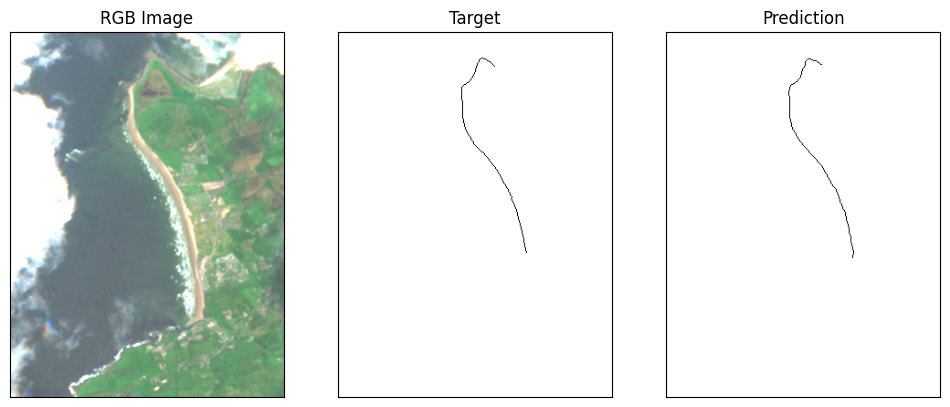

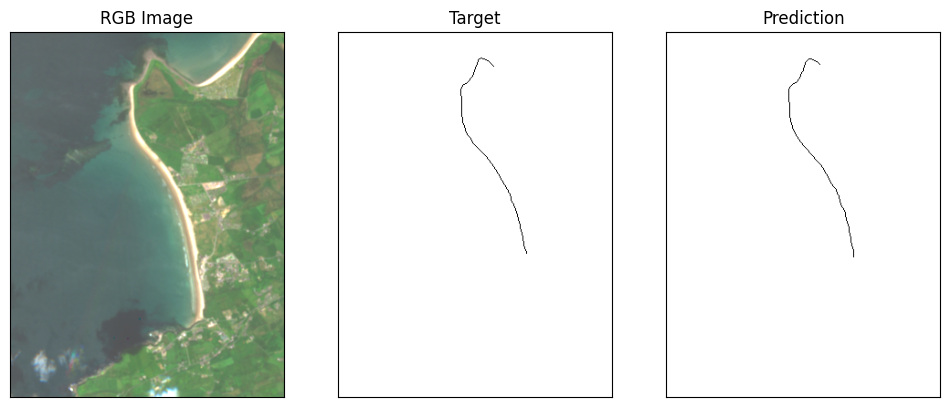

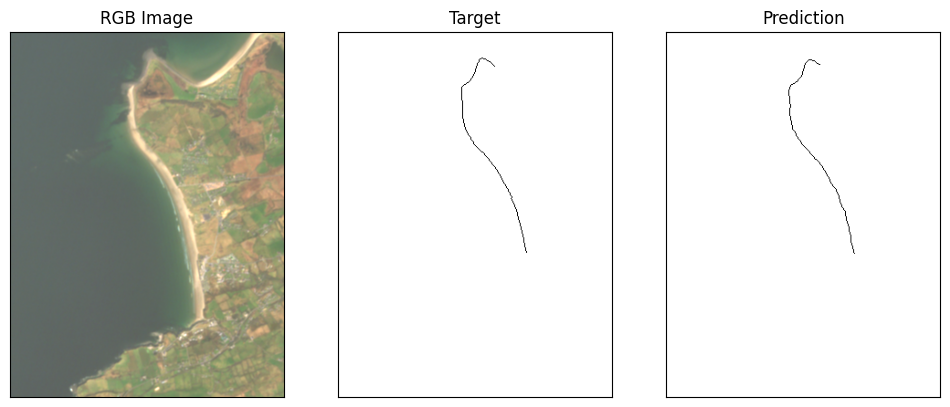

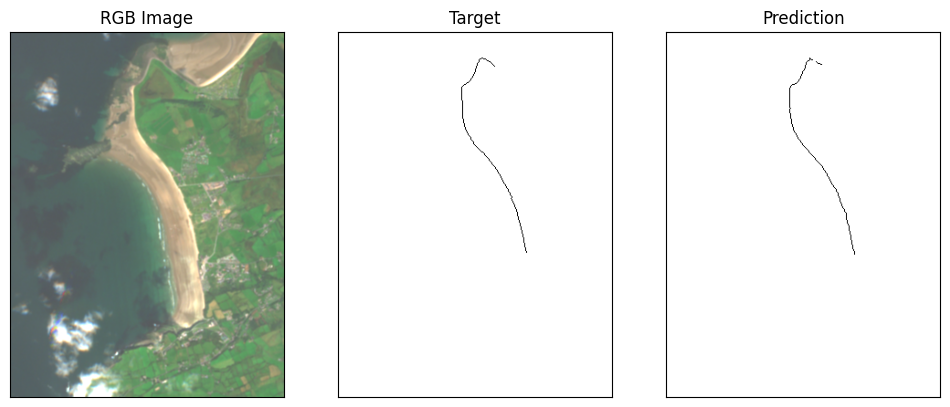

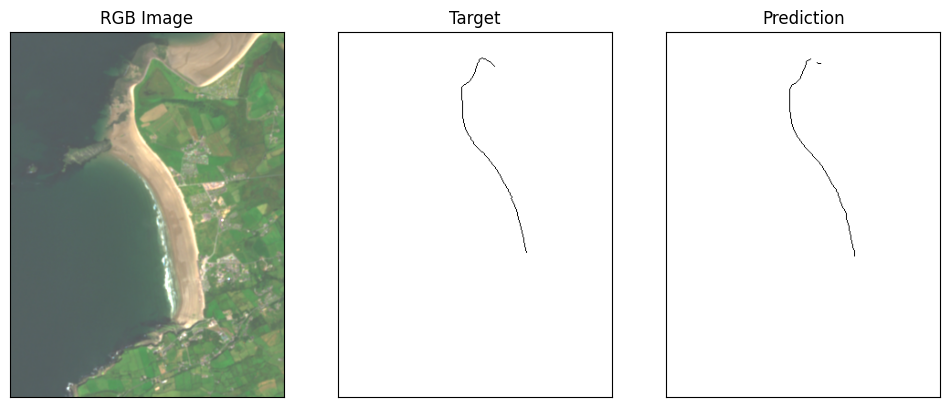

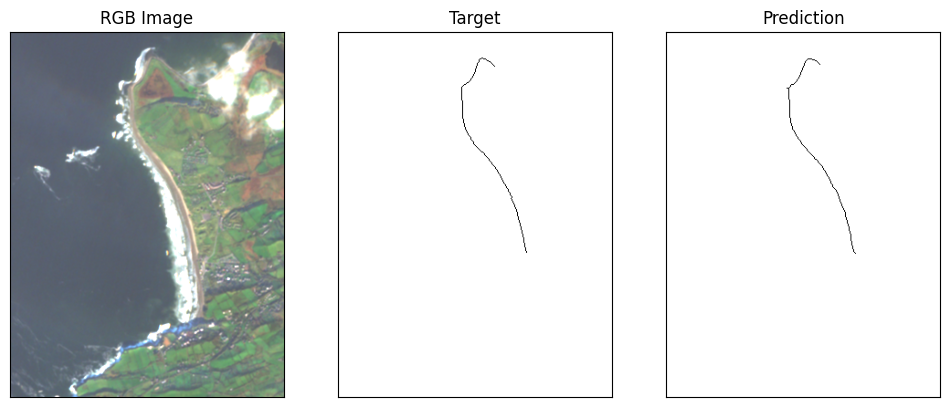

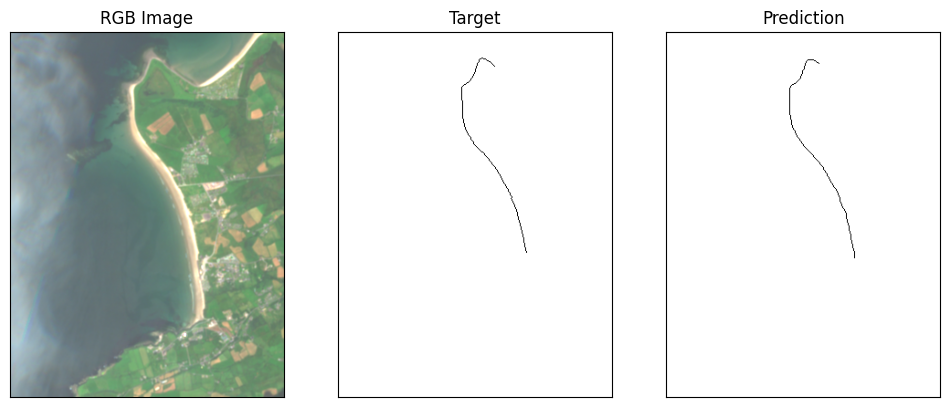

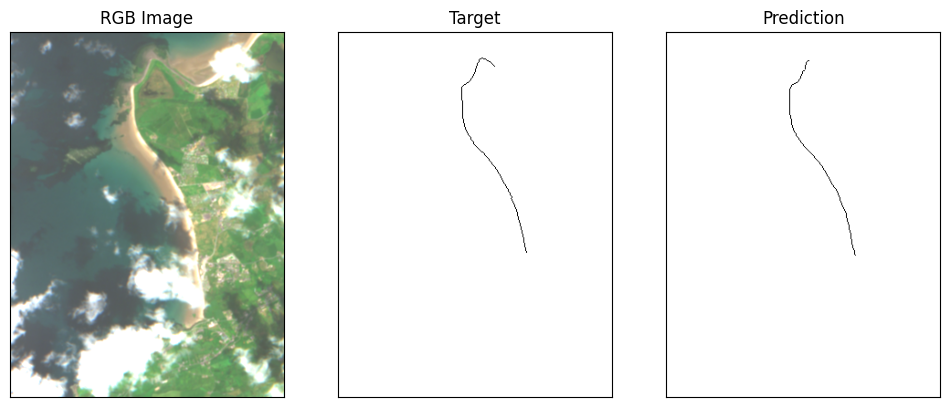

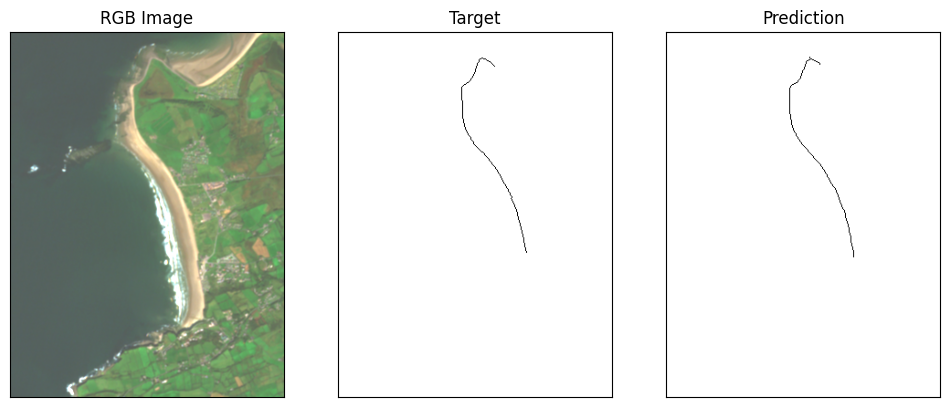

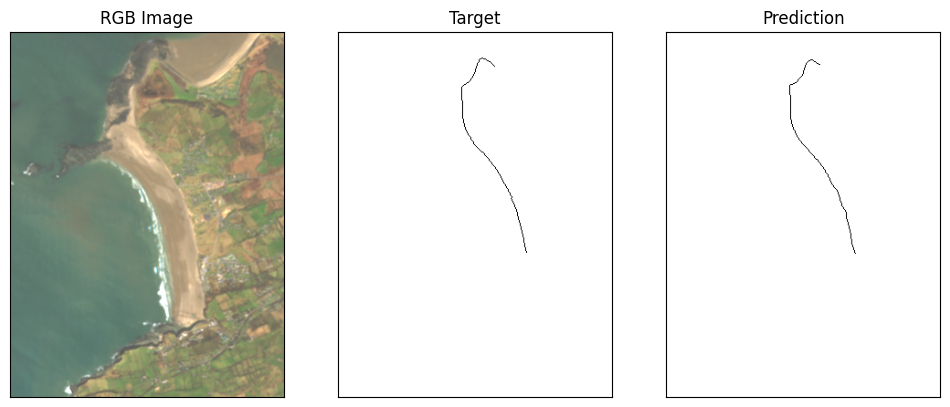

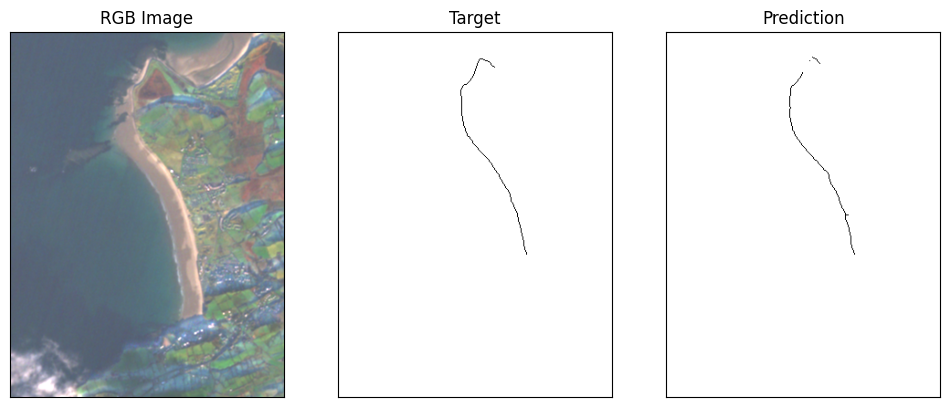

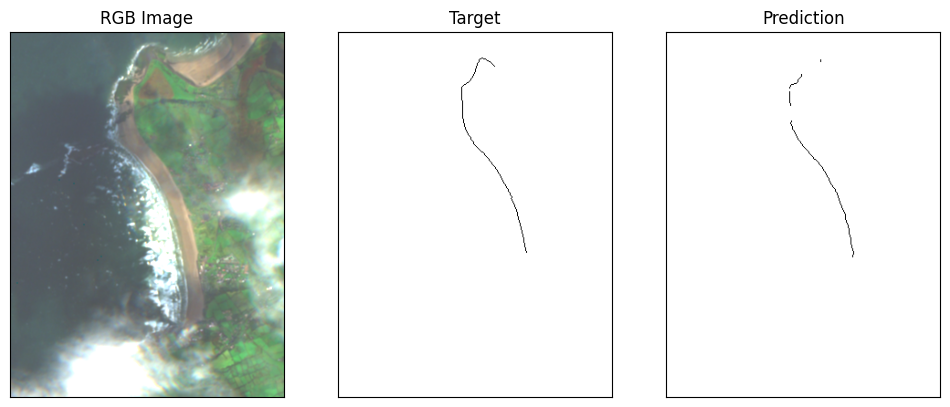

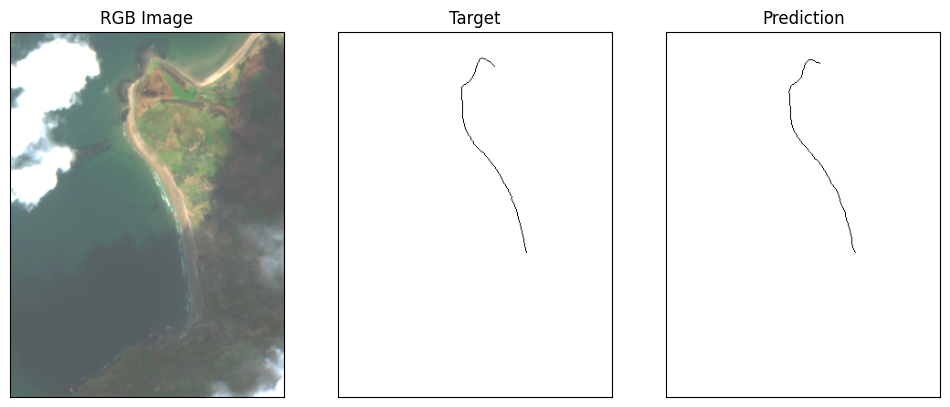

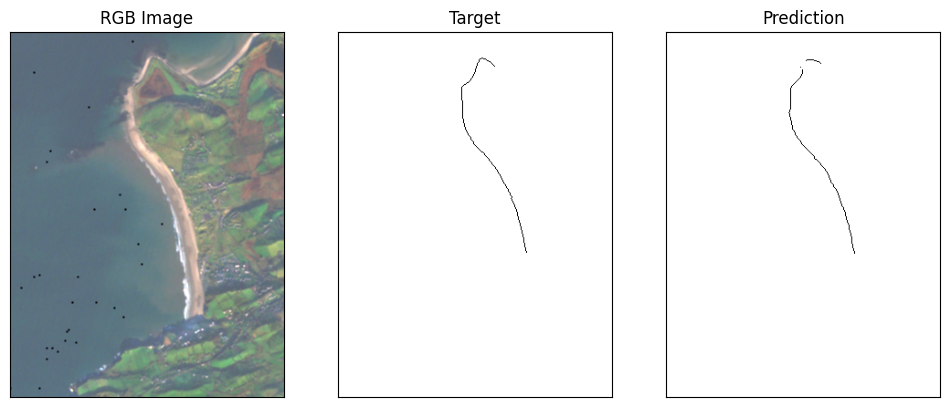

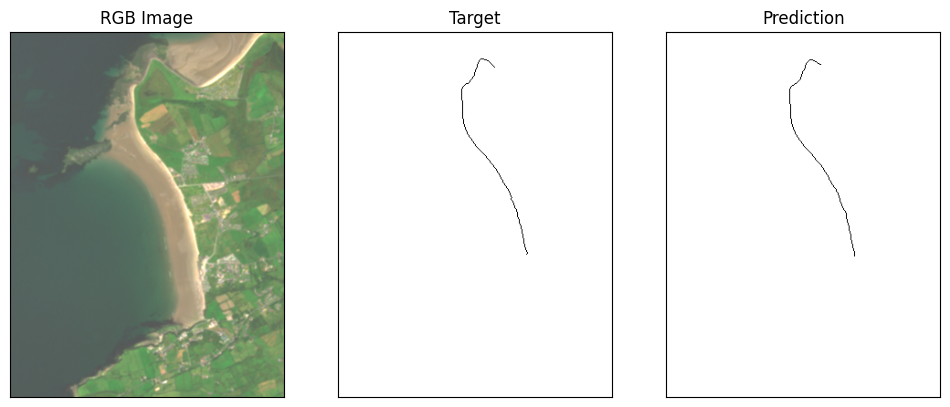

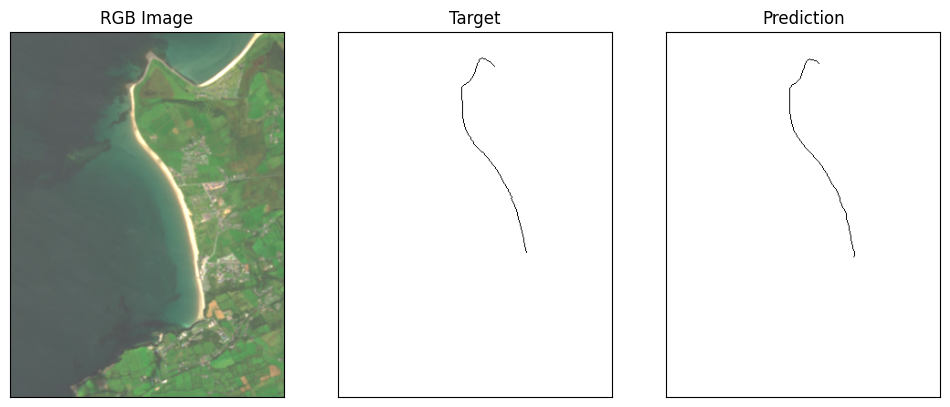

In [16]:
model_path = f'../models/SIVE_04JUN2025/{best_model_name}'
model, meta_data = utils.get_model(model_path)

print("Model metadata:")
for key, value in meta_data.items():
    print(f"{key}: {value}")

plot_all_predictions(model, meta_data, test_paths)

# Figures for paper

In [24]:
import matplotlib as mpl

blue = "#648fff" #2017
orange = "#fe6100" #2019
red = "#dc267f" #2021

figure_path = "/Users/conorosullivan/Google Drive/My Drive/1 UCD/0 research/JP02 - Vegetation Line/Figures"

In [20]:
def format_table(df):
    # Format the DataFrame as needed for the table
    format_df = df.copy()
    format_df = format_df.drop(columns=['name', 'date','arcitecture','accuracy','f1'])

    #capitalize
    format_df["freeze_backbone"] = [s.capitalize() for s in format_df["freeze_backbone"]]

    format_df["guidance"] = ["Yes" if b == True else "No" for b in format_df["guidance"]]

    format_df = format_df.sort_values(by=['backbone','freeze_backbone','loss_function','guidance',], ascending=True)
    format_df.columns = ['Backbone', 'Freeze Backbone', 'GB','Loss', 'Prec.', 'Rec.','IoU', 'FOM' ]
    format_df = format_df.round(4)

    return format_df

def group_by_top(df, group_cols, metric='FOM'):
    # Group by the specified columns and get the top row in each group based on the specified metric
    grouped = df[df[metric] == df.groupby(group_cols)[metric].transform('max')]
    return grouped

import pandas as pd

def dataframe_to_grouped_latex(
    df: pd.DataFrame, sublist: list, decimals: int = 2, col_space: str = "1em", save_path: str = None
):
    """
    Convert DataFrame to LaTeX table with grouped backbone rows.

    Parameters
    ----------
    df : pd.DataFrame
        Must contain 'Backbone' and 'Freeze Backbone' columns.
    save_path : str
        Path to save .tex file.
    
    decimals : int
        Number of decimal places for numeric columns.
    col_space : str
        Extra column spacing, e.g. '1.5em' or '10pt'.
    """

    df = df.copy()

    # Format numeric columns
    for col in df.columns:
        if pd.api.types.is_numeric_dtype(df[col]):
            max_val = df[col].max()
            df[col] = df[col].apply(
                lambda x: f"\\textbf{{{x:.{decimals}f}}}" if x == max_val else f"{x:.{decimals}f}"
            )

    # Format headers
    headers = []
    for col in df.columns:
        parts = col.split(" ")
        if len(parts) > 1:
            headers.append("\\textbf{" + parts[1] + "}")
        else:
            headers.append("\\textbf{" + col + "}")

    ncols = len(df.columns) - 1  # exclude Backbone column (handled separately)

    latex = []
    latex.append("\\begin{table}[!htb]")
    latex.append("\\caption{caption}")
    latex.append("\\label{tab:results_table_backbone}")
    latex.append("\\renewcommand{\\arraystretch}{1.2}")  # row height
    latex.append(f"\\setlength{{\\tabcolsep}}{{{col_space}}}")  # column spacing
    latex.append("\\centering")
    latex.append("\\begin{tabular}{" + "l" * (ncols ) + "}")
    latex.append("\\toprule")
    latex.append(" & ".join(headers[1:]) + " \\\\")
    latex.append("\\midrule")

    mainrow = sublist[0]
    subrow = sublist[1]

    # Group rows by backbone
    for ml, group in df.groupby(mainrow):
        # Backbone row
        latex.append(f"\\multicolumn{{{ncols}}}{{l}}{{\\underline{{{ml}}}}} \\\\")
        # Freeze backbone + rest of columns
        for _, row in group.iterrows():
            row_data = [str(row[subrow])] + [ "\multicolumn{1}{c}{" + str(v) + "}" for k, v in row.items() if k not in sublist]
            latex.append(" &  ".join(row_data) + " \\\\")

        latex.append("\\addlinespace")  # spacing between groups

    latex.append("\\bottomrule")
    latex.append("\\end{tabular}")
    latex.append("\\end{table}")


    if save_path:
        with open(save_path, "w") as f:
            f.write("\n".join(latex))
    else:
        print("\n".join(latex))

### Table 1: backbone and freeze backbone

In [21]:
# Initial formatting

results_df = pd.read_csv('../data/results/inlocation_results.csv')
results_df = format_table(results_df)

format_results = results_df.copy()
#round to 2 decimal places
format_results = group_by_top(format_results, ['Backbone', 'Freeze Backbone'], metric='FOM')

save_path = figure_path + "/results_table_backbone.tex"
dataframe_to_grouped_latex(format_results, sublist=['Backbone', 'Freeze Backbone'],save_path=save_path)

format_results

Backbone Freeze Backbone   GB  Loss   Prec.    Rec.     IoU     FOM
12  BigEarthNet          Frozen  Yes  DICE  0.5674  0.5477  0.3927  0.9119
4   BigEarthNet       Trainable  Yes  wBCE  0.6105  0.6200  0.4475  0.9528
0      ImageNet          Frozen  Yes  DICE  0.6032  0.5762  0.4206  0.9070
17     ImageNet       Trainable  Yes  wBCE  0.5890  0.6059  0.4296  0.9452
15    SimpleCNN       Trainable  Yes  wBCE  0.6085  0.6160  0.4460  0.9507

### Table 2: Guided and unguided results of unseen-location

In [22]:
# Results on unseen data
unseen_df = pd.read_csv('../data/results/outlocation_results.csv')
unseen_df = format_table(unseen_df)
unseen_df = unseen_df[(unseen_df['Backbone'] =='BigEarthNet') &
                      (unseen_df['Freeze Backbone'] == 'Trainable')]

unseen_df = group_by_top(unseen_df, ['GB'], metric='FOM')
unseen_df['Test Set'] = 'Unseen-location'

# Results on seen data
seen_df = pd.read_csv('../data/results/inlocation_results.csv')
seen_df = format_table(seen_df)
seen_df = seen_df[(seen_df['Backbone'] =='BigEarthNet') &
                  (seen_df['Freeze Backbone'] == 'Trainable')]

seen_df = group_by_top(seen_df, ['GB'], metric='FOM')
seen_df['Test Set'] = 'Seen-location'

combined_df = pd.concat([unseen_df, seen_df], axis=0)
combined_df = combined_df[['Test Set','GB', 'Prec.', 'Rec.','IoU', 'FOM']]
combined_df = combined_df.sort_values(by=['Test Set','GB'], ascending=False)

save_path = figure_path + "/results_table_unseenlocation.tex"
dataframe_to_grouped_latex(combined_df, sublist=['Test Set', 'GB'], save_path=save_path)
combined_df

Test Set   GB   Prec.    Rec.     IoU     FOM
4  Unseen-location  Yes  0.5353  0.5239  0.3690  0.9176
7  Unseen-location   No  0.3371  0.3441  0.2081  0.5749
4    Seen-location  Yes  0.6105  0.6200  0.4475  0.9528
2    Seen-location   No  0.5837  0.5644  0.4047  0.8980

### Figure 1: example of model applied to four AOIs


In [23]:
model_path = f'../models/SIVE_04JUN2025/SIVE_04JUN2025_HED_BigEarthNet_trainable_guided_wBCE.pth'
model, meta_data = utils.get_model(model_path)

print("Model metadata:")
for key, value in meta_data.items():
    print(f"{key}: {value}")

Model metadata:
name: SIVE_04JUN2025_HED_BigEarthNet_trainable_guided_wBCE.pth
date: 04JUN2025
arcitecture: HED
backbone: BigEarthNet
freeze_backbone: trainable
guidance: True
loss_function: wBCE


In [172]:
# Test data
target_pos = -1

test_file = '../data/SIVE/test_1/'
test_paths = glob.glob(test_file + '*.npy')
test_targets = [np.load(file)[target_pos] for file in test_paths]
test_input = [np.load(file)[0:target_pos] for file in test_paths]

In [99]:
def get_max_pos(edge_map,location,buffer =20,):
    """Find boarders of edge map:
    Returns:
    x1: minimum x position of an edge pixel
    x2: maximum x position of an edge pixel
    y1: minimum y position of an edge pixel
    y2: maximum y position of an edge pixel
    """

    edge_pixels = np.argwhere(edge_map)

    x1 = np.min(edge_pixels[:,1]) - buffer
    x2 = np.max(edge_pixels[:,1]) + buffer
    y1 = np.min(edge_pixels[:,0]) - buffer
    y2 = np.max(edge_pixels[:,0]) + buffer

    if location in ["Portmarnock"]:
        # Adjust the coordinates for Tramore
        x1 -= 50
        x2 += 50
    if location in ["Tramore"]:
        # Adjust the coordinates for Tramore
        y1 -= 50
        y2 += 50


    return x1,x2,y1,y2

In [ ]:
def edge_map_to_colour(edge_map,colour):
    """Convert binary edge map to coloured edge map.
    Input:
    edge_map: 2D binary numpy array
    colour: String representing the color (e.g. '#ff0000')
    """

    coloured_map = np.zeros((*edge_map.shape, 4))  # RGBA
    coloured_map[edge_map == 1] = [*mpl.colors.to_rgb(colour), 1]  # Set color and full opacity
    return coloured_map


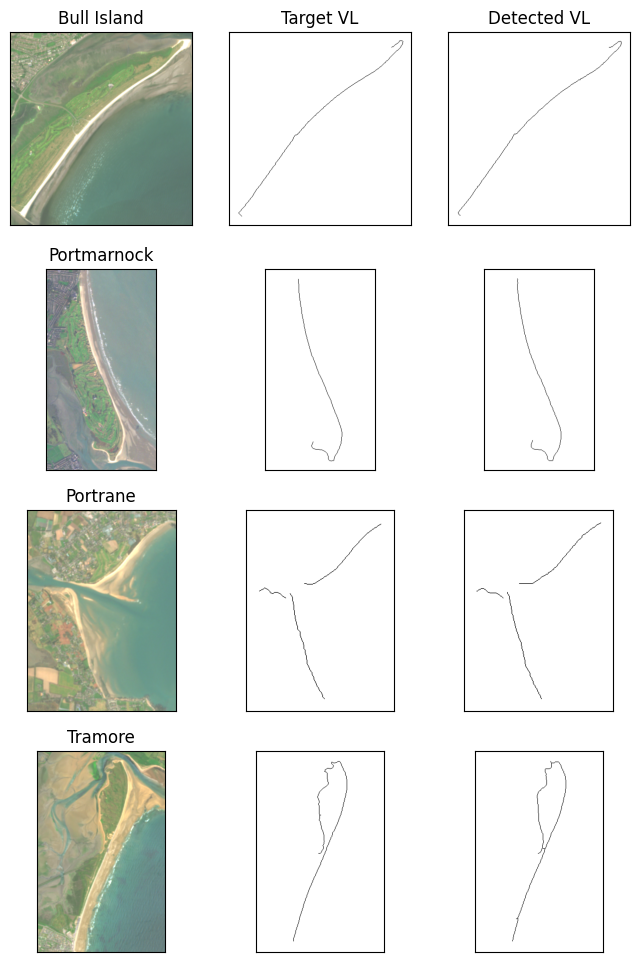

In [174]:
crop_remove = 200
fig, ax = plt.subplots(4, 3, figsize=(8, 12))

locations = ["Bull Island","Portmarnock","Portrane","Tramore"]
test_path_locations = [7, 1, 0, 2]

for i, path_loc in enumerate(test_path_locations):
        path = test_paths[path_loc]
        image,  pred_full = eval.get_combined_pred(model,meta_data,points_dict, path, batch_size=1)

        target_edge = image[-1]

        location = locations[i]
        x1,x2,y1,y2 = get_max_pos(pred_full,location)


        image = image[:,y1:y2,x1:x2]
        target_edge = target_edge[y1:y2,x1:x2]
        pred_full = pred_full[y1:y2,x1:x2]

        ID = os.path.basename(path).split('.')[0]
        points = points_dict[ID][1]

        rgb_image = utils.get_rgb(image, r=0,b=2,contrast=0.3)
        rgb_image = utils.enhance_rgb(rgb_image,1.5)

        if location in ["Tramore"]:
            # rotate images
            rgb_image = np.rot90(rgb_image)
            target_edge = np.rot90(target_edge)
            pred_full = np.rot90(pred_full)

        ax[i, 0].imshow(rgb_image)
        ax[i, 0].set_title(location)

        ax[i, 1].imshow(1-target_edge, cmap='gray')
        ax[i, 2].imshow(1-pred_full, cmap='gray')
        
for a in ax.flatten():
    a.set_xticks([])
    a.set_yticks([])
        
ax[0, 1].set_title("Target VL")
ax[0, 2].set_title("Detected VL")

save_path = os.path.join(figure_path, "example_results_seenlocation.png")
fig.savefig(save_path, bbox_inches='tight', dpi=300)

### Figure 2: zoomed in view

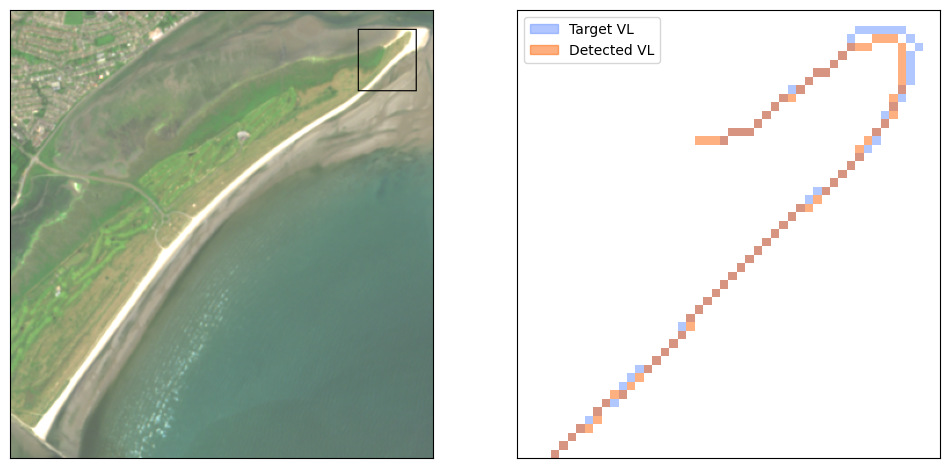

In [176]:
import cv2
import matplotlib.patches as mpatches

path = test_paths[7]
image,  pred_full = eval.get_combined_pred(model,meta_data,points_dict, path, batch_size=1)

target_edge = image[-1]

location = "Bull Island"
x1,x2,y1,y2 = get_max_pos(pred_full,location)

image = image[:,y1:y2,x1:x2]
target_edge = target_edge[y1:y2,x1:x2]
pred_full = pred_full[y1:y2,x1:x2]

ID = os.path.basename(path).split('.')[0]
points = points_dict[ID][1]

rgb_image = utils.get_rgb(image, r=0,b=2,contrast=0.3)
rgb_image = utils.enhance_rgb(rgb_image,1.5)

#crop_x1, crop_x2, crop_y1, crop_y2 = 200,250,105,150

crop_x1, crop_x2, crop_y1, crop_y2 = 300,350,17,70

target_edge = target_edge[crop_y1:crop_y2, crop_x1:crop_x2]
target_edge = edge_map_to_colour(target_edge,blue)

pred_full = pred_full[crop_y1:crop_y2, crop_x1:crop_x2]
pred_full = edge_map_to_colour(pred_full,orange)

# draw black square on rgb_image
cv2.rectangle(rgb_image, (crop_x1, crop_y1), (crop_x2, crop_y2), (0, 0, 0), 1)

fig, ax = plt.subplots(1, 2, figsize=(12, 6))

ax[0].imshow(rgb_image)

ax[1].imshow(target_edge, alpha=0.5)
ax[1].imshow(pred_full, alpha=0.5)

# Add custom legend with two colours
blue_patch = mpatches.Patch(color=blue, label='Target VL',alpha=0.5)
orange_patch = mpatches.Patch(color=orange, label='Detected VL',alpha=0.5)
ax[1].legend(handles=[blue_patch, orange_patch], loc='upper left')


for a in ax.flatten():
    a.set_xticks([])
    a.set_yticks([])

save_path = os.path.join(figure_path, "rough/example_results_bull_island.png")
fig.savefig(save_path, bbox_inches='tight', dpi=300)

### Figure 3: guided vs unguided on unseen-location

In [148]:
# Test data
target_pos = -1

test_file = '../data/SIVE/test_2/'
test_paths = glob.glob(test_file + '*.npy')
test_targets = [np.load(file)[target_pos] for file in test_paths]
test_input = [np.load(file)[0:target_pos] for file in test_paths]

print("Test dimensions:")
print(np.shape(test_targets[0]))
print(np.shape(test_input[0]))

Test dimensions:
(800, 700)
(5, 800, 700)


In [151]:
model_path = f'../models/SIVE_04JUN2025/SIVE_04JUN2025_HED_BigEarthNet_trainable_unguided_wBCE.pth'
unguided_model, unguided_meta_data = utils.get_model(model_path)

print("Model metadata:")
for key, value in meta_data.items():
    print(f"{key}: {value}")

Model metadata:
name: SIVE_04JUN2025_HED_BigEarthNet_trainable_unguided_wBCE.pth
date: 04JUN2025
arcitecture: HED
backbone: BigEarthNet
freeze_backbone: trainable
guidance: False
loss_function: wBCE


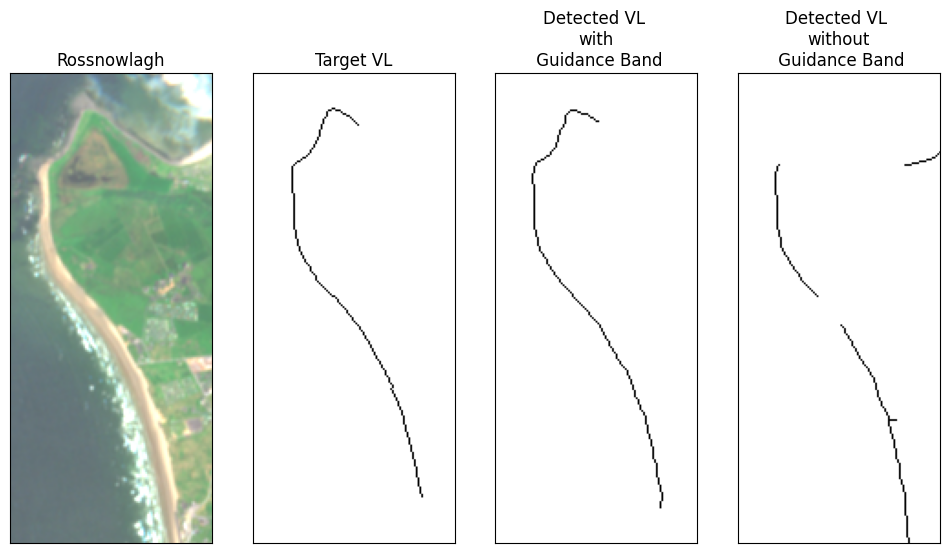

In [170]:
path = test_paths[0]

fig,ax = plt.subplots(1, 4, figsize=(12,12))

# Guided 
image,  pred_full = eval.get_combined_pred(model,meta_data,points_dict, path, batch_size=1)

target_edge = image[-1]
x1,x2,y1,y2 = get_max_pos(pred_full,location='Rossnowlagh')

image = image[:,y1:y2,x1:x2]
target_edge = target_edge[y1:y2,x1:x2]
pred_full = pred_full[y1:y2,x1:x2]

rgb_image = utils.get_rgb(image, r=0,b=2,contrast=0.3)
rgb_image = utils.enhance_rgb(rgb_image,1.5)

ax[0].imshow(rgb_image)
ax[0].set_title("Rossnowlagh")

ax[1].imshow(1-target_edge, cmap='gray')
ax[1].set_title("Target VL")

ax[2].imshow(1-pred_full, cmap='gray')
ax[2].set_title("Detected VL \nwith\n Guidance Band")

# Unguided
image, pred_full = eval.get_combined_pred(unguided_model,unguided_meta_data,points_dict, path, batch_size=1)
pred_full = pred_full[y1:y2,x1:x2]

ax[3].imshow(1-pred_full, cmap='gray')
ax[3].set_title("Detected VL \nwithout\n Guidance Band")

for a in ax.flatten():
    a.set_xticks([])
    a.set_yticks([])

save_path = os.path.join(figure_path, "example_results_unseenlocation.png")
fig.savefig(save_path, bbox_inches='tight', dpi=300)